In [1]:
### Start of the Project


In [2]:
### Importing Libraries 

In [3]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# miscellaneous
import time
import warnings
warnings.filterwarnings("ignore")


In [4]:
### 1. Load the dataset

In [5]:
# Load files into a pandas dataframe
train = pd.read_csv('data/Train 2.csv')
test = pd.read_csv('data/Test.csv')
ss = pd.read_csv('data/SampleSubmission.csv')
variables = pd.read_csv('data/VariableDefinitions 2.csv')

In [6]:
# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
print('test data shape :', test.shape)

train data shape : (23524, 13)
test data shape : (10086, 12)


In [7]:
# inspect train data
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [8]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64


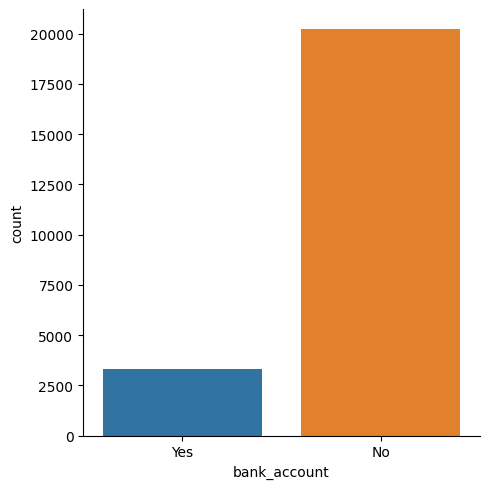

In [9]:
# Explore Target distribution 
sns.catplot(x="bank_account", kind="count", data=train)

In [25]:
# view the submission file
ss.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


In [26]:
### 2. Understand the dataset

In [27]:
 #show some information about the dataset
 print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  int64 
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(4), object(9)
memory usage: 2.3+ MB
None


In [28]:
categorical_features = list(train.select_dtypes(include=['object']).columns)
numerical_features   = list(train.select_dtypes(exclude=['object']).columns)
numerical_features   = list(set(numerical_features) - set('bank_account')) #remove 'bank_account' target from num_feat.

categorical_features, numerical_features

(['country',
  'uniqueid',
  'location_type',
  'cellphone_access',
  'gender_of_respondent',
  'relationship_with_head',
  'marital_status',
  'education_level',
  'job_type'],
 ['bank_account', 'household_size', 'year', 'age_of_respondent'])

In [29]:
# Let's view the variables
variables

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


In [30]:
### 3. Data preparation for machine learning

In [31]:
#import preprocessing module
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Cobvert target label to numerical Data
le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])

#Separate training features from target
X_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']

print(y_train)

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int64


In [32]:
# Create transformers for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # You can change the strategy as needed
    ('scaler',  StandardScaler())
])

In [48]:
# Create transformers for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # You can change the strategy as needed
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

In [56]:
# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer,   numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


['country', 'uniqueid', 'location_type', 'cellphone_access', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']


In [35]:
estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier',   LogisticRegression(max_iter=10_000))
    ])

In [36]:
param_grid = {
#     'preprocessor__num__poly__degree': [2,3,4],
     'preprocessor__num__imputer__strategy': ['mean', 'median'],
     'preprocessor__num__scaler': [StandardScaler(),MinMaxScaler(), None],
     'classifier__penalty': ['l1', 'l2'],
     'classifier__C': [0.1, 1.0,10.]
}

In [43]:
gscv = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5, 
    n_jobs=-1,
    verbose=1
)

In [51]:
print(y_train)

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int64


In [52]:
X_Train, X_Val, y_Train, y_val = train_test_split(X_train, y_train, stratify = y_train, 
                                                  test_size = 0.1, random_state=42)

In [63]:
# Check column names
print("Column Names:", X_train.columns)

# Check data types
print("Data Types:", X_train.dtypes)

Column Names: Index(['country', 'year', 'uniqueid', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'],
      dtype='object')
Data Types: country                   object
year                       int64
uniqueid                  object
location_type             object
cellphone_access          object
household_size             int64
age_of_respondent          int64
gender_of_respondent      object
relationship_with_head    object
marital_status            object
education_level           object
job_type                  object
dtype: object


In [57]:
%timeit gscv.fit(X_Train,y_Train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


ValueError: 
All the 180 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jannisweber/Documents/Bootcamp Data Science/Github/ml_project_Team_C/.venv/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3652, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 147, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 176, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'bank_account'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/jannisweber/Documents/Bootcamp Data Science/Github/ml_project_Team_C/.venv/lib/python3.11/site-packages/sklearn/utils/__init__.py", line 448, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jannisweber/Documents/Bootcamp Data Science/Github/ml_project_Team_C/.venv/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3654, in get_loc
    raise KeyError(key) from err
KeyError: 'bank_account'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/jannisweber/Documents/Bootcamp Data Science/Github/ml_project_Team_C/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jannisweber/Documents/Bootcamp Data Science/Github/ml_project_Team_C/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jannisweber/Documents/Bootcamp Data Science/Github/ml_project_Team_C/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jannisweber/Documents/Bootcamp Data Science/Github/ml_project_Team_C/.venv/lib/python3.11/site-packages/joblib/memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jannisweber/Documents/Bootcamp Data Science/Github/ml_project_Team_C/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jannisweber/Documents/Bootcamp Data Science/Github/ml_project_Team_C/.venv/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jannisweber/Documents/Bootcamp Data Science/Github/ml_project_Team_C/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py", line 724, in fit_transform
    self._validate_column_callables(X)
  File "/Users/jannisweber/Documents/Bootcamp Data Science/Github/ml_project_Team_C/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py", line 426, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jannisweber/Documents/Bootcamp Data Science/Github/ml_project_Team_C/.venv/lib/python3.11/site-packages/sklearn/utils/__init__.py", line 456, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [ ]:
### BIS HIERHIN KLAPPT ALLES

In [24]:
#import classifier algorithm here
from xgboost import XGBClassifier

# create models
xg_model = XGBClassifier()

#fitting the models
xg_model.fit(X_Train,y_Train)

ModuleNotFoundError: No module named 'xgboost'

In [26]:
# import evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score

# evaluate the model
xg_y_model = xg_model.predict(X_Val)

# Get error rate
print("Error rate of XGB classifier: ", 1 - accuracy_score(y_val, xg_y_model))

ModuleNotFoundError: No module named 'sklearn'

In [27]:
from sklearn.metrics import plot_confusion_matrix

# Get confusion matrix for Gradient Boosting Classifier
plot_confusion_matrix(xg_model,X_Val, y_val,normalize='true')

ModuleNotFoundError: No module named 'sklearn'

In [28]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Optimize model parameters
# I run this code in google colab to make the execution much faster and use the best params in the next code
param_grid = {'min_child_weighth': [1, 5, 10],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 5]
        }
my_xgb_model = GridSearchCV(xg_model, param_grid,n_jobs=-1,verbose=2,cv=5)
my_xgb_model.fit(X_Train, y_Train)
print(my_xgb_model.best_params_)        

ModuleNotFoundError: No module named 'sklearn'

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score

# fit by setting best parameters and Evaluate model
xgb_model = XGBClassifier(min_child_weight=1, gamma=1, subsample=0.8, max_depth=5)

xgb_model.fit(X_Train, y_Train)
y_pred = xgb_model.predict(X_Val)

# Get error rate
print("Error rate of the XGB classifier: ", 1 - accuracy_score(y_val, y_pred))

ModuleNotFoundError: No module named 'sklearn'

In [30]:
# Get the predicted result for the test Data
test.bank_account = xgb_model.predict(processed_test)

NameError: name 'xgb_model' is not defined